# Tradução EN->PT

In [15]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.style.use('default')
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap, TSNE
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, TimeDistributed, Embedding, GlobalAveragePooling1D, Flatten, SimpleRNN, GRU, Dropout, LSTM, Bidirectional
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import os
import re

# Aula 21: Tradução automática
**Objetivo: ao fim desta aula o aluno será capaz de explicar o funcionamento e testar redes tipo seq2seq para fazer tradução automática de textos**


# Exercício 1
*Objetivo: modelar o problema de tradução como uma caixa-preta com entradas e saídas*

Até o momento, fizemos diversos sistemas de classificação e predição em que nossos modelos têm várias entradas e apenas uma saída. Porém, quando queremos traduzir um texto, nossa entrada é uma sequência de palavras e a saída também.

Desenhe um diagrama de blocos mostrando as entradas e saídas de uma possível rede neural que faz traduções.

# Exercício 2
*Objetivo: explicar o que são bancos de dados alinhados*

O código abaixo lê um *banco de dados alinhado*. Analisando o conteúdo de `lines_pt` e `lines_en`, descubra:

1. Qual é o conteúdo de um banco de dados alinhado?
1. Qual é a dificuldade em gerá-lo?

In [16]:
max_lines = 500
lines_pt = []
with open('./datasets/en_pt.pt', 'r+') as f:
    curr_line = 0
    for line in f:
        curr_line = curr_line +1
        lines_pt.append(line)
        if curr_line >= max_lines:
            break

lines_en = []
with open('./datasets/en_pt.en', 'r+') as f:
    curr_line = 0
    for line in f:
        curr_line = curr_line +1
        lines_en.append(line)
        if curr_line >= max_lines:
            break


In [17]:
print(lines_pt[0])

nessa tese apresentamos duas linhas de pesquisa distintas, a saber, na primeira, referente aos capítulos 1 e 3 aplicamos técnicas estatísticas à análise de imagens do satélite de abertura sintética (sar) e, na segunda, referente ao capítulo 2, examinamos problemas relativos à estimação de parâmetros por máxima verossimilhança na distribuição exponencial-poisson.



In [18]:
print(lines_en[0])

in this thesis we present two distinct research lines, namely, the first, referring to chapters 2 and 3, apply statistical techniques to the analysis of synthetic aperture radar (sar) images, and the second, referring to chapter 4, we examined problems concerning parameter estimation by maximum likelihood in exponential-poisson distribution.



# Exercício 3
*Objetivo: entender como modelar uma rede neural para tradução*

O código abaixo tem uma rede neural que mapeia sequências para sequências.

1. Como as entradas são representadas?
1. Como as saídas são representadas?
1. O que significa o parâmetro `return_state=True` na primeira camada LSTM?
1. O que significa o parâmetro `return_sequences=True` na primeira camada LSTM?
1. Como as sequências e o estado da primeira camada LSTM se propagam para a camada seguinte? 

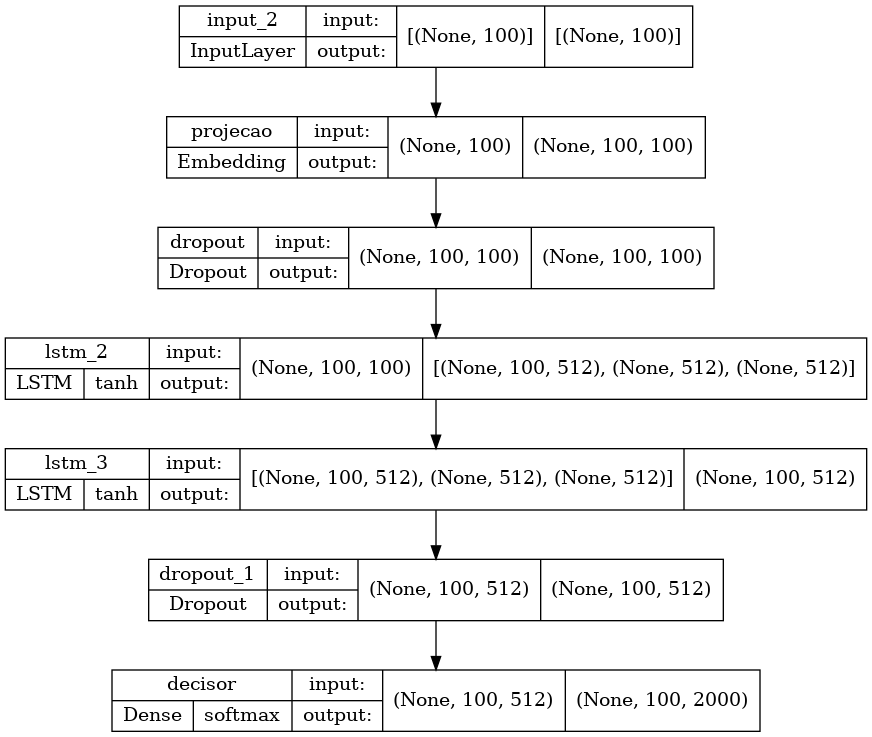

In [19]:
vocab_size_pt = 2000
vocab_size_en = 2000
def rede_neural_traducao(input_dims, vocab_size, dim_latente, dim_out):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  x = Embedding(vocab_size, dim_latente, name='projecao')(x)
  x = Dropout(0.2)(x)
  x,state_h, state_c = LSTM(512, return_sequences=True, return_state=True)(x)

  x = LSTM(512, return_sequences=True) (x, initial_state=[state_h, state_c])
  x = Dropout(0.2)(x)
  y = Dense(dim_out, activation='softmax', name='decisor')(x)
  return Model(input_layer, y)

rede_neural = rede_neural_traducao(100, vocab_size_pt, 100, vocab_size_en)
rede_neural.compile(optimizer='adam', loss='categorical_crossentropy')
plot_model(rede_neural, show_shapes=True, show_layer_activations=True)

# Exercício 4
*Objetivo: analisar um código de pré-processamento de sequências*

Analise o código de pré-processamento abaixo, que prepara as sequências alinhadas para serem inseridas na rede neural.

1. Que representação é usada para os textos em português?
1. Que representação é usada para os textos em inglês?
1. Isso corresponde às entradas e saídas da rede neural que foi definida acima?

In [20]:
# Tokenizar linhas - pt & en

# Entradas serao em portugues!
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences


tokenizer_pt = Tokenizer(num_words=vocab_size_pt)
tokenizer_pt.fit_on_texts(lines_pt)
sequences_pt = tokenizer_pt.texts_to_sequences(lines_pt)
sequences_pt = pad_sequences(sequences_pt, maxlen=100)

In [21]:
X = np.array(sequences_pt)
print(X.shape)

(500, 100)


In [22]:
# Saidas serao em ingles / one-hot encooding
tokenizer_en = Tokenizer(num_words=vocab_size_en)
tokenizer_en.fit_on_texts(lines_en)
sequences_en = tokenizer_en.texts_to_sequences(lines_en)
sequences_en = pad_sequences(sequences_en, maxlen=100)

y_ = np.array(sequences_en)
y_ = y_.reshape(y_.shape[0]*y_.shape[1],1)

onehot_encoder = OneHotEncoder(sparse=False)
y = onehot_encoder.fit_transform(y_)
y = y.reshape(max_lines, 100, vocab_size_en)
print(y.shape)

# Teste de sanidade!
_i = np.argmax(y[15,91,:])
_j = sequences_en[15,91]
print(_i, _j)

(500, 100, 2000)
4 4


# Exercício 5
*Objetivo: treinar a rede neural*

Execute o código abaixo para treinar e testar a rede neural.

1. A rede neural treinada consegue traduzir frases que fazem parte do conjunto de treino?
1. A rede neural consegue traduzir frases que são parecidas, mas não iguais, ao conjunto de treino?
1. A rede neural consegue traduzir frases arbitrárias?
1. Por que, neste caso, não usamos early stopping? O que acontece com as avaliações acima se passarmos a usar?

In [23]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = rede_neural.fit(X, y, epochs=700)#, validation_split=0.2, callbacks=es)

2022-05-19 17:34:51.471986: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 400000000 exceeds 10% of free system memory.
2022-05-19 17:34:52.062784: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 400000000 exceeds 10% of free system memory.


Epoch 1/700
16/16 [==============================] - 5s 37ms/step - loss: 3.5799
Epoch 2/700
16/16 [==============================] - 1s 34ms/step - loss: 2.1959
Epoch 3/700
16/16 [==============================] - 1s 31ms/step - loss: 2.0450
Epoch 4/700
16/16 [==============================] - 1s 31ms/step - loss: 1.8901
Epoch 5/700
16/16 [==============================] - 1s 36ms/step - loss: 1.8224
Epoch 6/700
16/16 [==============================] - 1s 36ms/step - loss: 1.7709
Epoch 7/700
16/16 [==============================] - 1s 32ms/step - loss: 1.7432
Epoch 8/700
16/16 [==============================] - 1s 31ms/step - loss: 1.7244
Epoch 9/700
16/16 [==============================] - 1s 32ms/step - loss: 1.7184
Epoch 10/700
16/16 [==============================] - 1s 35ms/step - loss: 1.7025
Epoch 11/700
16/16 [==============================] - 1s 36ms/step - loss: 1.6863
Epoch 12/700
16/16 [==============================] - 1s 36ms/step - loss: 1.7180
Epoch 13/700
16/16 [=====

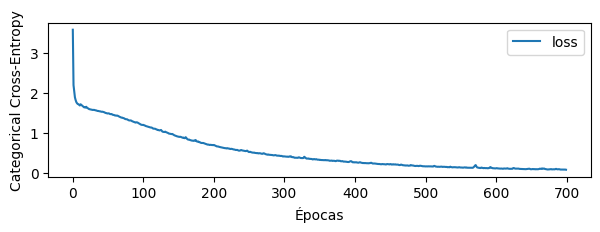

In [24]:
plt.figure(figsize=(7,2))
plt.plot(history.history['loss'], label='loss')
#plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Épocas')
#plt.semilogy()
plt.ylabel('Categorical Cross-Entropy')
plt.legend()
plt.show()

## Teste

In [29]:
# frase_de_teste=lines_pt[2]
frase_de_teste="este ruido leva a resultados ruins"
tokens = tokenizer_pt.texts_to_sequences([frase_de_teste])
tokens = pad_sequences(tokens, maxlen=100)
tokens = np.array(tokens)
print(tokens.shape)

(1, 100)


In [30]:
y_predict = rede_neural.predict(tokens)
y_sequence = np.argmax(y_predict, axis=2)
print(y_sequence)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0 1090  836    2   79
    14    4]]


In [31]:
y_text = tokenizer_en.sequences_to_texts(y_sequence)
print(y_text)

['pharmaceutical itself of group on in']


In [28]:
lines_en[2]

'this noise leads to quite unsatisfactory results when conventional methods of image analysis are applied.\n'

# Exercício 6
*Objetivo: discutir outras aplicações de seq2seq*

As topologias `seq2seq` servem para modelar mapeamentos entre sequências.

1. Escolha uma aplicação em que isso poderia ser útil
1. Defina: qual seria o público-alvo e qual seria o ganho de valor ao usar a aplicação.
1. Quais dados seriam necessários para treinar a rede neural para esta aplicação?
